# Figure 2: Multilayer learning: Backprop vs Hebb

In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import h5py

import EIANN as eiann
import EIANN.utils as ut
from EIANN.generate_figures import *
eiann.update_plot_defaults()

In [2]:
def plot_E_pop_representations(model_list, model_dict_all, figure_name):
    fig = plt.figure(figsize=(6.5, 5))
    axes = gs.GridSpec(nrows=3, ncols=len(model_list), figure=fig,                    
                        left=0.07,right=0.66, top=0.93, bottom=0.28,
                        wspace=0.32, hspace=0.4)

    axes_bargraphs = gs.GridSpec(nrows=1, ncols=len(model_list), figure=fig,      
                        left=0.07,right=0.68, top=0.2, bottom=0.05,
                        wspace=0.2)

    axes_metrics = gs.GridSpec(nrows=5, ncols=1, figure=fig,
                        left=0.8,right=0.99, top=0.93, bottom=0.05,
                        wspace=0.8, hspace=0.3, height_ratios=[1, 0.05, 1, 1, 1])
    ax_accuracy    = fig.add_subplot(axes_metrics[0])  
    ax_sparsity   = fig.add_subplot(axes_metrics[2])
    ax_selectivity = fig.add_subplot(axes_metrics[3])

    root_dir = ut.get_project_root()

    model_dict_all["vanBP"]["display_name"] = "Feedforward ANN \n Backprop"
    model_dict_all["bpDale_learned"]["display_name"] = "EIANN \n Backprop"
    model_dict_all["HebbWN_topsup"]["display_name"] = "EIANN \n Hebb + Weight Norm."
    
    model_dict_all["BTSP_WT_hebbdend"]["label"] = "BTSP"

    for col, model_key in enumerate(model_list):
        model_dict = model_dict_all[model_key]
        network_name = model_dict['config'].split('.')[0]
        hdf5_path = root_dir + f"/EIANN/data/model_hdf5_plot_data/plot_data_{network_name}.h5"
        with h5py.File(hdf5_path, 'r') as f:
            data_dict = f[network_name]
            # print(f"Generating plots for {model_dict['label']}")

            #########################################################
            # Example heatmaps for E populations
            #########################################################
            example_seed = model_dict['seeds'][0]
            for row, population in enumerate(['OutputE','H2E','H1E']):
                # Activity plots: batch accuracy of each population to the test dataset
                ax = fig.add_subplot(axes[row, col])
                average_pop_activity_dict = data_dict[example_seed]['average_pop_activity_dict']
                num_units = average_pop_activity_dict[population].shape[1]
                eiann.plot_batch_accuracy_from_data(average_pop_activity_dict, population=population, sort=True, ax=ax, cbar=False)    
                ax.set_yticks([0,num_units-1])
                ax.set_yticklabels([1,num_units])
                if col == 0:
                    ax.set_ylabel(f'{population} unit', labelpad=-7 if row==0 else -10)
                else:
                    ax.set_yticklabels([])
                    ax.set_ylabel('')
                    if col==len(model_list)-1:
                        pos = ax.get_position()                
                        cbar_ax = fig.add_axes([pos.x1 + 0.01, pos.y0, 0.008, pos.height])                
                        cbar = matplotlib.colorbar.ColorbarBase(cbar_ax, cmap='viridis', orientation='vertical')
                        cbar.set_label('Normalized class-\naveraged activity', labelpad=14, rotation=270)
                        cbar.set_ticks([0, 1])
                if row == 0:
                    ax.set_title(model_dict["display_name"])
                ax.set_xlabel(ax.get_xlabel(), labelpad=0)

            ###############################
            # Class confusion bar graphs
            ###############################
            ax = fig.add_subplot(axes_bargraphs[0, col])
            plot_confusion_all_seeds(data_dict, model_dict, ax=ax, population='H1E')
            if col>0:
                ax.set_ylabel('')

            #################
            # Plot metrics
            #################
            plot_accuracy_all_seeds(data_dict, model_dict, ax=ax_accuracy, legend=True)

            populations_to_plot = ['H1E', 'H2E']
            plot_metric_all_seeds(data_dict, model_dict, populations_to_plot=populations_to_plot, ax=ax_sparsity, metric_name='sparsity', plot_type='violin', side='both')
            plot_metric_all_seeds(data_dict, model_dict, populations_to_plot=populations_to_plot, ax=ax_selectivity, metric_name='selectivity', plot_type='violin', side='both')
            ax_sparsity.set_ylabel(f"Sparsity\n(hidden layers)", labelpad=-2)
            ax_selectivity.set_ylabel(f"Selectivity\n(hidden layers)", labelpad=-2)
            ax_sparsity.set_xticklabels([])

    # # Add subplot labels/letters
    # mosaic = """
    #         ABCD
    #         ...E
    #         ...F
    #         G...
    #         """
    # axes_labels_dict = fig.subplot_mosaic(
    #     mosaic,
    #     gridspec_kw={"left": 0.019, "right": 0.93,
    #                 "bottom": 0.02, "top": 0.97, 
    #                 "wspace": 0., "hspace": 0., 
    #                 "width_ratios":[1.3, 1.1, 1.2, 1]},)
    # for label in 'ABCDEFG':
    #     axes_labels_dict[label].set_axis_off()
    #     axes_labels_dict[label].text(0., 1., label, transform=axes_labels_dict[label].transAxes, ha='center', va='top', 
    #                                 fontsize=8, fontname='Helvetica')

    fig.savefig(f"{root_dir}/EIANN/figures/{figure_name}.svg", dpi=300)
    fig.savefig(f"{root_dir}/EIANN/figures/{figure_name}.png", dpi=300)

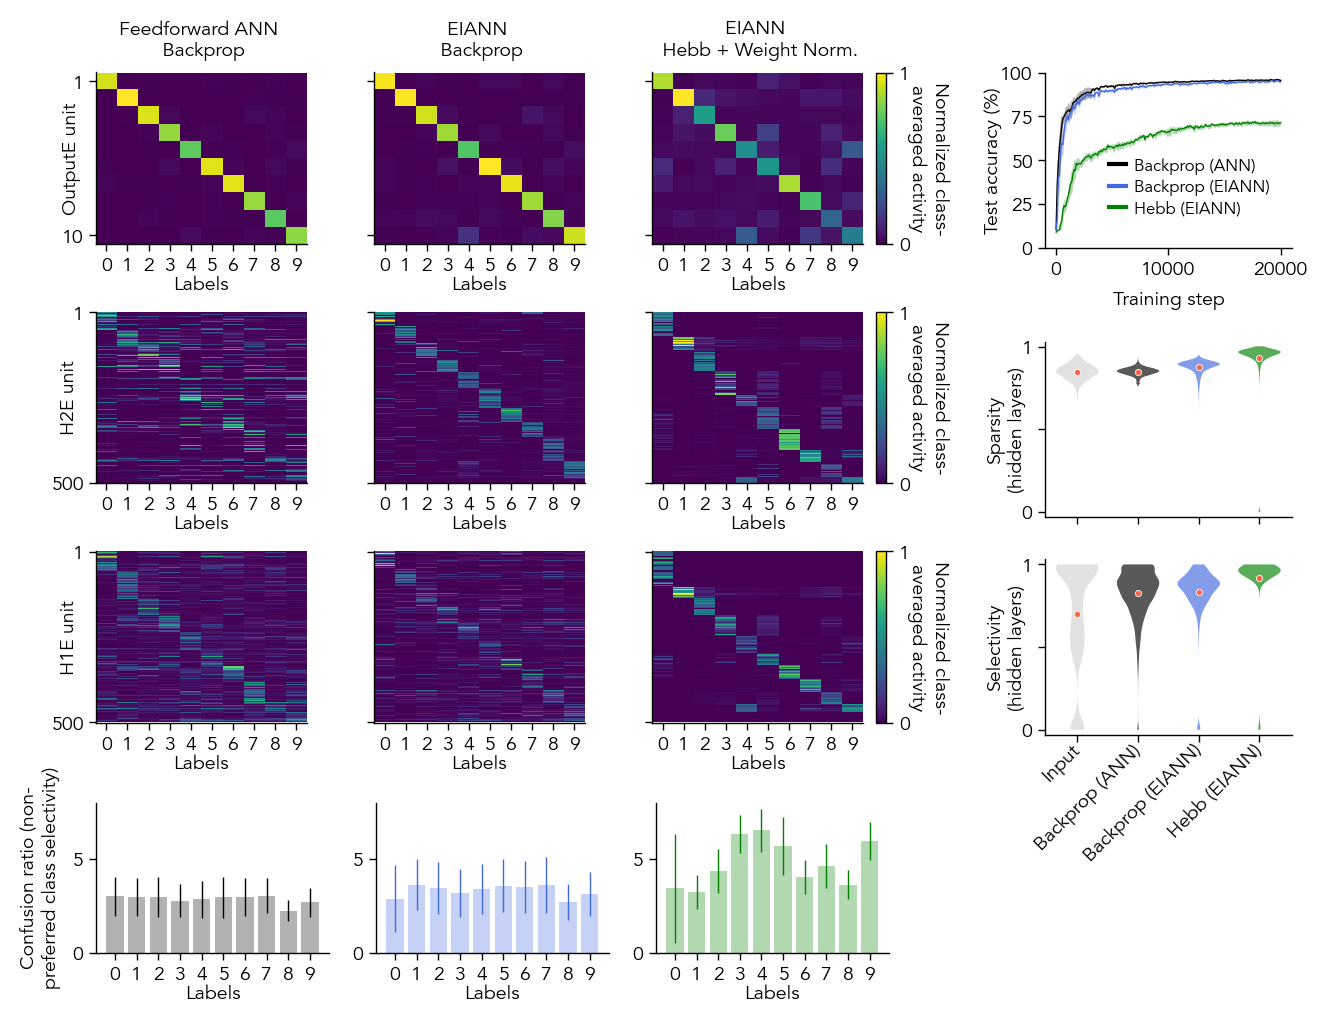

In [3]:
figure_name = "Fig2_vanBP_bpDale_hebb"
model_list = ["vanBP", "bpDale_learned", "HebbWN_topsup"]

model_dict_all = load_model_dict()
generate_hdf5_all_seeds(model_list, model_dict_all, variables_to_save=["average_pop_activity_dict", "metrics_dict"], recompute=None)

plot_E_pop_representations(model_list, model_dict_all, figure_name)